# The relationship between pupil size and activity in visual cortex

## Imports and constants

In [1]:
from datamatrix import io, plot
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datamatrix import operations as ops, DataMatrix, FloatColumn

In [2]:
MAX_ERR = np.inf
MIN_X = 2
MAX_X = 158
MIN_Y = 2
MAX_Y = 126
MIN_SD = 1
MAX_SD = 62
XC = 80
YC = 64
OUTLIERS = set()
SRC_NIFTI = '../outputs/correlation-matrix.pkl'
SRC_LONGISH = '../outputs/longish-correlation-matrix.csv'
VISUAL_CORTEX = {'V1', 'V2', 'V3', 'V4'}
LGN = 'LGN'
COLORS = {
    'V1': '#4DB6AC',
    'V2': '#009688',
    'V3': '#00796B',
    'V4': '#004D40',
    'LGN': 'red'
}

## Read data

The data is read in two formats:

- A DataMatrix `dm` with one row for each roi/ subject, and the imaging data as NiftiColumns
- A "longish" DataMatrix `ldm` with one row for each voxel

The data is filtered based on the PRF properties to avoid poorly fitted PRFs from being included in the analysis.

In [3]:
def mask(nft, mask):
    
    """Set voxels that match the mask to nan"""
    
    nft.get_data()[mask] = np.nan


dm = io.readpickle(SRC_NIFTI)
dm = dm.roi == VISUAL_CORTEX
dm = dm.sub != OUTLIERS
for row in dm:
    if row.roi == 'LGN':
        continue
    a = row.prf_err.get_data()
    x = row.prf_x.get_data()
    y = row.prf_y.get_data()
    sd = row.prf_sd.get_data()
    err = np.where(
        (a > MAX_ERR) |
        (x < MIN_X) | (x >= MAX_X) |
        (y < MIN_Y) | (y >= MAX_Y) |
        (sd < MIN_SD) | (sd >= MAX_SD)
    )
    n_poor = len(err[0])
    n_total = np.sum(~np.isnan(a))
    mask(row.prf_x, err)
    mask(row.prf_y, err)
    mask(row.prf_sd, err)
    mask(row.prf_err, err)
    mask(row.r_vc_pupil, err)
    mask(row.r_vc_lum, err)
dm.r_pupil = [np.nanmedian(row.r_vc_pupil.get_data()) for row in dm]
dm.r_lum = [np.nanmedian(row.r_vc_lum.get_data()) for row in dm]
dm.m_prf_err = [np.nanmedian(row.prf_err.get_data()) for row in dm]
dm.m_prf_sd = [np.nanmedian(row.prf_sd.get_data()) for row in dm]
dm.m_prf_absx = [np.nanmedian(np.abs(row.prf_x.get_data() - XC)) for row in dm]
dm.m_prf_absy = [np.nanmedian(np.abs(row.prf_y.get_data() - YC)) for row in dm]
dm.m_prf_ecc = [
    np.nanmedian(
        (
            (row.prf_y.get_data() - XC) ** 2 +
            (row.prf_y.get_data() - YC) ** 2
        ) ** .5
    )
    for row in dm
]
# And now the longish matrix
ldm = io.readtxt(SRC_LONGISH)
ldm_lgn = ldm.roi == LGN
print('Number of LGN voxels included in analysis: {}'.format(len(ldm_lgn)))
print('Total number VC of voxels: {}'.format(len(ldm)))
ldm = ldm.roi == VISUAL_CORTEX
ldm = ldm.prf_err <= MAX_ERR
ldm = ldm.prf_x > MIN_X
ldm = ldm.prf_x <= MAX_X
ldm = ldm.prf_y > MIN_Y
ldm = ldm.prf_y <= MAX_Y
ldm = ldm.prf_sd > MIN_SD
ldm = ldm.prf_sd <= MAX_SD
ldm = ldm.sub != OUTLIERS
print('Number of VC voxels included in analysis: {}'.format(len(ldm)))

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater_equal


Number of LGN voxels included in analysis: 360
Total number VC of voxels: 55080
Number of VC voxels included in analysis: 30382


# Plot: Correlations between pupil size, luminance, and visual-cortex activity

In [4]:
def roi_hist(ldm, col):
    
    plt.xlim(-.25, .25)
    plt.axvline(0, color='black', linestyle='-')
    for roi, rdm in ops.split(ldm.roi):
        sns.distplot(
            rdm[col],
            label='{} (N={})'.format(roi, len(rdm[col])),
            hist=True,
            kde=False,
            bins=20,
            hist_kws={
                "alpha": .8,
                "color": COLORS[roi]
            }
        )
        plt.axvline(rdm[col].mean, color=COLORS[roi], linestyle=':')
    plt.ylabel('Voxel count')
    plt.xlabel('Correlation (r)')
    plt.legend()

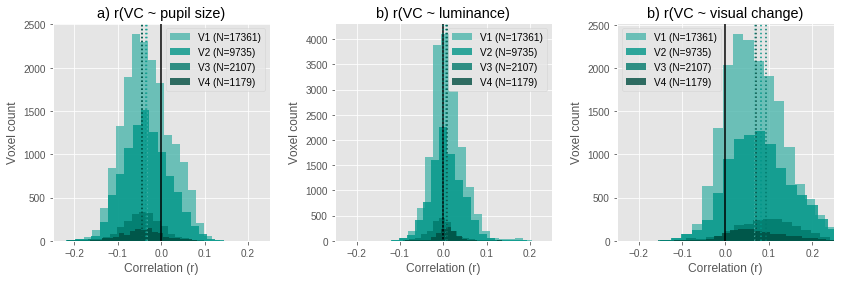

In [5]:
plt.figure(figsize=(14, 4))
plt.subplots_adjust(wspace=.3)
# Correlated pupil size and visual cortex
plt.subplot(1,3,1)
plt.title('a) r(VC ~ pupil size)')
roi_hist(ldm, 'r_vc_pupil')
# Correlated luminance and visual cortex
plt.subplot(1,3,2)
plt.title('b) r(VC ~ luminance)')
roi_hist(ldm, 'r_vc_lum')
plt.subplot(1,3,3)
plt.title('b) r(VC ~ visual change)')
roi_hist(ldm, 'r_vc_change')
plot.save('correlation-plot-dist', show=True)

(-0.55, 0.55)

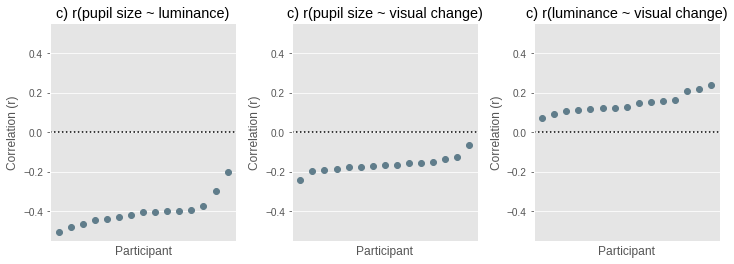

In [6]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=.3)
plt.subplot(1,3,1)
# Correlated pupil size and luminance
plt.ylabel('Correlation (r)')
plt.title('c) r(pupil size ~ luminance)')
plt.axhline(0, color='black', linestyle=':')
r = sorted([sdm.r_lum_pupil.mean for sub, sdm in ops.split(dm.sub)])
plt.plot(r ,'o', color='#607D8B')
plt.xlabel('Participant')
plt.ylim(-.55, .55)
plt.xticks([])
plt.subplot(1,3,2)
# Correlated pupil size and luminance
plt.ylabel('Correlation (r)')
plt.title('c) r(pupil size ~ visual change)')
plt.axhline(0, color='black', linestyle=':')
r = sorted([sdm.r_change_pupil.mean for sub, sdm in ops.split(dm.sub)])
plt.plot(r ,'o', color='#607D8B')
plt.xlabel('Participant')
plt.xticks([])
plt.ylim(-.55, .55)
plt.subplot(1,3,3)
# Correlated pupil size and luminance
plt.ylabel('Correlation (r)')
plt.title('c) r(luminance ~ visual change)')
plt.axhline(0, color='black', linestyle=':')
r = sorted([sdm.r_lum_change.mean for sub, sdm in ops.split(dm.sub)])
plt.plot(r ,'o', color='#607D8B')
plt.xlabel('Participant')
plt.xticks([])
plt.ylim(-.55, .55)

# Plot: PRF properties

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


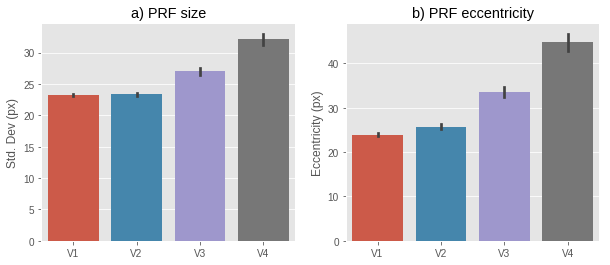

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('a) PRF size')
sns.barplot(x='roi', y='prf_sd', data=ldm)
plt.ylabel('Std. Dev (px)')
plt.subplot(1, 2, 2)
plt.title('b) PRF eccentricity')
sns.barplot(x='roi', y='ecc', data=ldm)
plt.ylabel('Eccentricity (px)')
plot.save('prf-properties-bar', show=True)

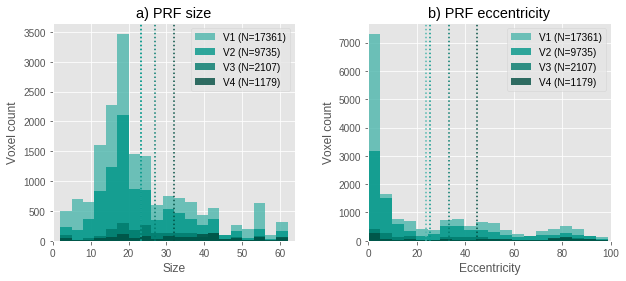

In [8]:
plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=.3)
plt.subplot(1, 2, 1)
plt.title('a) PRF size')
roi_hist(ldm, 'prf_sd')
plt.xlabel('Size')
plt.xlim(0, 64)
plt.subplot(1, 2, 2)
plt.title('b) PRF eccentricity')
roi_hist(ldm, 'ecc')
plt.xlabel('Eccentricity')
plt.xlim(0, 100)
plot.save('prf-properties', show=True)

# Heatmaps

Various heatmaps to inspect how properties are distributed across the visual field, across all ROIs and for each ROI separately.

First some helper functions.

In [9]:
def density_map(ldm, downsample=8):

    a = np.zeros((2 * YC // downsample, 2 * XC // downsample))
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.r_vc_pupil
        a[y, x] += 1
    plt.axis('off')
    sns.heatmap(a, cbar=False)
    
    
def size_map(ldm, downsample=16):

    a = np.empty((len(ldm), 2 * YC // downsample, 2 * XC // downsample))
    a[:] = np.nan
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.prf_sd
        a[i, y, x] = r
    heatmap = np.nanmean(a, axis=0)
    plt.axis('off')
    sns.heatmap(heatmap, cbar=False)
        
    
def correlation_map(ldm, downsample=16):

    a = np.empty((len(ldm), 2 * YC // downsample, 2 * XC // downsample))
    a[:] = np.nan
    for i, row in enumerate(ldm):
        x = row.prf_x // downsample
        y = row.prf_y // downsample
        r = row.r_vc_pupil
        a[i, y, x] = r
    heatmap = np.nanmean(a, axis=0)
    plt.axis('off')
    sns.heatmap(heatmap, cbar=False, center=0)
    
    
def roi_plot(ldm, fnc):
        
    plt.figure(figsize=(15, 3))
    plt.subplots_adjust(wspace=.1, hspace=.1)
    plt.subplot(1, 5, 1)
    plt.title('All (V1 - V4)')
    fnc(ldm)
    plt.subplot(1, 5, 2)
    plt.title('V1')
    fnc(ldm.roi == 'V1')
    plt.subplot(1, 5, 3)    
    plt.title('V2')
    fnc(ldm.roi == 'V2')
    plt.subplot(1, 5, 4)    
    plt.title('V3')
    fnc(ldm.roi == 'V3')
    plt.subplot(1, 5, 5)
    plt.title('V4')
    fnc(ldm.roi == 'V4')


The density of PRFs.

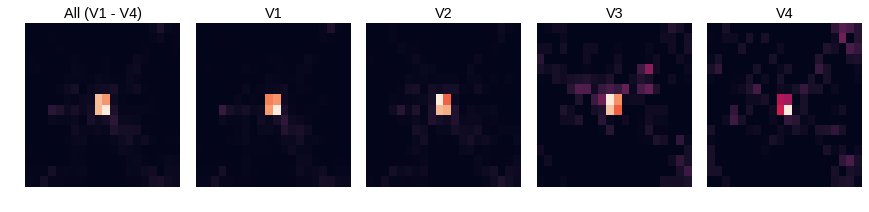

In [10]:
roi_plot(ldm, density_map)
plot.save('map-density', show=True)

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice


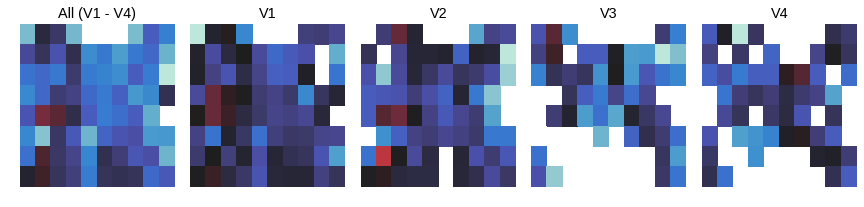

In [11]:
roi_plot(ldm, correlation_map)
plot.save('map-correlation', show=True)

/home/sebastiaan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


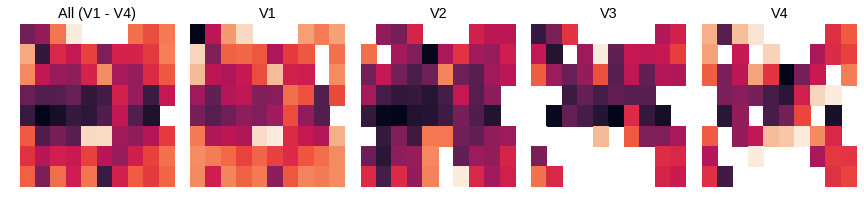

In [12]:
roi_plot(ldm, size_map)
plot.save('map-prf-size', show=True)

# Statistics

In [13]:
from datamatrix.rbridge import lme4
lme4.verbose = True

## Relationship between PRF properties and the VC-pupil correlation.

In [14]:
lme4.lmer(ldm, 'r_vc_pupil ~ (1|sub)')

df,effect,est,p,se,t
14.0008755439492,(Intercept),-0.0341366206991661,0.00161965400760526,0.00876579377870117,-3.89429885769274


In [15]:
lme4.lmer(ldm, 'r_vc_pupil ~ r_vc_lum + (1+r_vc_lum|sub)')

df,effect,est,p,se,t
14.0032402827611,(Intercept),-0.0284427737708673,0.00276585397930101,0.00784966266420389,-3.62343899191647
13.9666977163656,r_vc_lum,-0.517823380690242,0.000770621577245304,0.121066559782674,-4.27717927741389


In [16]:
ldm.c_roi = ldm.roi @ (lambda roi: 0 if roi == 'V1' else 1 if roi == 'V2' else 2 if roi == 'V3' else 3)
lme4.lmer(ldm, 'r_vc_pupil ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
14.0019870645091,(Intercept),-0.0323643508474074,0.00518429418912106,0.00978537582460037,-3.30742032064253
14.0380173638301,c_roi,-0.00296931435375754,0.264403581973199,0.00255418599429885,-1.16252863353933


In [17]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_y + (1+prf_y|sub)')

df,effect,est,p,se,t
42.4335889399685,(Intercept),-0.0459439451878322,7.27449150436283e-08,0.00706947621756295,-6.49891785104135
19.1936012257823,prf_y,0.000173401828071532,0.0021508664932052,4.89567472193022e-05,3.54193932237322


In [18]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_x + (1+prf_x|sub)')

df,effect,est,p,se,t
22.0607929143391,(Intercept),-0.0281307440110495,0.00543350862106946,0.00912641481962847,-3.0823433480744
18.3852519172716,prf_x,-8.2513752422622e-05,0.041841916491774,3.77185063266283e-05,-2.1876198306498


In [19]:
lme4.lmer(ldm, 'r_vc_pupil ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
47.5254727178109,(Intercept),-0.0341270679246758,4.86663245212808e-07,0.00586392326588618,-5.81983535207779
15.6414101618801,ecc,1.63429732526709e-05,0.799174564550953,6.31523130982844e-05,0.258786613678524


In [20]:
lme4.lmer(ldm, 'r_vc_pupil ~ prf_sd + (1+prf_sd|sub)')

df,effect,est,p,se,t
14.2583520176401,(Intercept),-0.0321969909037184,0.0124285485839095,0.0112600665314206,-2.85939615133486
14.1503277839589,prf_sd,-0.000102975927116728,0.576893145166604,0.000180312911103416,-0.57109569407189


## Basic PRF properties as a function of ROI

In [21]:
lme4.lmer(ldm, 'ecc ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
14.0260150866935,(Intercept),23.1354726471499,8.60983945378574e-08,2.30148252679545,10.052421592513
13.9812663126696,c_roi,5.30937250974727,0.00112760109034772,1.30123264204,4.08026384999343


In [22]:
lme4.lmer(ldm, 'prf_sd ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
14.0013136975219,(Intercept),22.9111894769519,4.61011216535057e-09,1.80747198085128,12.6758199959267
14.0099467599685,c_roi,2.26248033877315,0.000287197841963537,0.472303268084342,4.79031269029696


In [23]:
lme4.lmer(ldm, 'prf_sd ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
22.2222854906384,(Intercept),18.4996382138764,5.96117638217953e-11,1.58513606548376,11.6706941547195
15.7079699613809,ecc,0.224889816146787,9.80236555950877e-12,0.0128245234038992,17.5359199764423


## Relationship between luminance and VC activity

In [24]:
lme4.lmer(ldm, 'r_vc_lum ~ (1|sub)')

df,effect,est,p,se,t
13.9994315000022,(Intercept),0.00882498269877528,0.117579317718877,0.0052917033444574,1.66770170667611


In [25]:
lme4.lmer(ldm, 'r_vc_lum ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
14.0010356259088,(Intercept),0.01071048017291,0.0997563633919686,0.00607618859570403,1.76269712570846
14.0537763366122,c_roi,-0.00313598689887875,0.113182913098292,0.00185620262435855,-1.68946367046672


In [26]:
lme4.lmer(ldm, 'r_vc_lum ~ prf_y + (1+prf_y|sub)')

df,effect,est,p,se,t
14.2542004012757,(Intercept),-0.0163547986574673,0.0783577379754474,0.00862404289565662,-1.89641898299279
14.1622088223083,prf_y,0.000369529814775712,0.000776746550939156,8.67894353983082e-05,4.25777415280795


In [27]:
lme4.lmer(ldm, 'r_vc_lum ~ prf_x + (1+prf_x|sub)')

df,effect,est,p,se,t
27.5353418346884,(Intercept),0.000668623574187428,0.903644694832763,0.00547249671979994,0.122178889896506
17.869522713235,prf_x,9.67172344556087e-05,0.0155085880285608,3.61529405531314e-05,2.67522455921588


In [28]:
lme4.lmer(ldm, 'r_vc_lum ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
28.4086660464472,(Intercept),0.00829689492625549,0.0844401520825839,0.00464019369398904,1.78804926548721
19.0690463132925,ecc,3.75099313580564e-05,0.368266062613669,4.07021972169873e-05,0.92157018349863


In [29]:
lme4.lmer(ldm, 'r_vc_lum ~ prf_sd + (1+prf_sd|sub)')

df,effect,est,p,se,t
14.217661849049,(Intercept),0.00395552426622177,0.519455194955996,0.00598814747117481,0.660558926656784
14.1573471042265,prf_sd,0.000175476129326902,0.178008440449215,0.000123804751310779,1.41736183360536


## Relationship between visual change and VC activity

In [30]:
lme4.lmer(ldm, 'r_vc_change ~ (1|sub)')

df,effect,est,p,se,t
14.0012019477521,(Intercept),0.0757521397967056,4.61680592175703e-07,0.00863679752898391,8.77085974778172


In [31]:
lme4.lmer(ldm, 'r_vc_change ~ c_roi + (1+c_roi|sub)')

df,effect,est,p,se,t
14.0125242395584,(Intercept),0.0715307218333971,1.01867362810564e-06,0.00872242764023455,8.2007813402134
14.1712077638561,c_roi,0.00715611810135379,0.00149137182095883,0.0018230603766882,3.92533247546836


In [32]:
lme4.lmer(ldm, 'r_vc_change ~ prf_y + (1+prf_y|sub)')

df,effect,est,p,se,t
2.47810824628764,(Intercept),0.0629794172414745,0.044447098345184,0.0165864392550544,3.79704264869765
3.52372407254673,prf_y,0.000189901851776631,0.194236502086927,0.00011865659836769,1.60043229275938


In [33]:
lme4.lmer(ldm, 'r_vc_change ~ prf_x + (1+prf_x|sub)')

df,effect,est,p,se,t
5.53652654434878,(Intercept),0.0765654224806745,0.00338611919248436,0.0156232237961364,4.90074414088653
6.72059129171766,prf_x,1.18384073641621e-05,0.897388460723505,8.83999161038071e-05,0.133918762437063


In [34]:
lme4.lmer(ldm, 'r_vc_change ~ ecc + (1+ecc|sub)')

df,effect,est,p,se,t
1.69702606866653,(Intercept),0.0599979038497463,0.0638959424604999,0.0136215157405405,4.40464225806972
12.072535814305,ecc,0.000665901726587086,3.40487975178609e-05,0.000104361267661844,6.38073627799131


In [35]:
lme4.lmer(ldm, 'r_vc_change ~ prf_sd + (1+prf_sd|sub)')

df,effect,est,p,se,t
14.1123965536674,(Intercept),0.0659631489870975,0.000293088044073912,0.0138315949610294,4.7690197097984
14.0002746373336,prf_sd,0.000607069098740934,0.0892427915162342,0.000332450728564187,1.82604231719627
